# Plot power thresholds

Generic libraries:

In [1]:
from functools import partial
from pathlib import Path
import tomllib

import numpy as np

Other libraries required for this notebook:

In [2]:
from multipac_testbench.test_campaign import TestCampaign
import multipac_testbench.instruments as ins
from multipac_testbench.util.post_treaters import running_mean
from multipac_testbench.util.multipactor_detectors import \
    quantity_is_above_threshold

Define the project path, load the configuration.

In [3]:
project = Path("../data/campaign")
config_path = Path(project, "testbench_configuration.toml")

with open(config_path, "rb") as f:
    config = tomllib.load(f)

In [4]:
frequencies = (120., 120., 120., 120., 120.)
swrs = (1., 2., 4., 10., np.inf)
info = ('', '', '', '', 'short-circuit')
filepaths = (
    Path(project, "120MHz_travelling.csv"),
    Path(project, "120MHz_SWR2.csv"),
    Path(project, "120MHz_SWR4.csv"),
    Path(project, "120MHz_SWR10.csv"),
    Path(project, "120MHz_short-circuit.csv")
)
test_campaign = TestCampaign.from_filepaths(filepaths,
                                            frequencies,
                                            swrs,
                                            config,
                                            info=info,
                                            sep='\t')

[INFO    ] [factory.py          ] 1 set of global diagnostics defined:
	GlobalDiagnostic global, with instruments: ['ForwardPower (NI9205_Power1)', 'ReflectedPower (NI9205_Power2)', 'ReflectionCoefficient (Reflection_coefficient)', 'SWR (SWR)', 'Frequency (Reference frequency)']
[INFO    ] [factory.py          ] 10 pick-ups created:
[INFO    ] [factory.py          ] 	Pick-Up E1 at z = 0.000m, with instruments: ['CurrentProbe (NI9205_MP1l)', 'FieldProbe (NI9205_E1)']
[INFO    ] [factory.py          ] 	Pick-Up V1 at z = 0.130m, with instruments: ['Penning (NI9205_Penning1)']
[INFO    ] [factory.py          ] 	Pick-Up E2 at z = 0.260m, with instruments: ['CurrentProbe (NI9205_MP2l)', 'FieldProbe (NI9205_E2)']
[INFO    ] [factory.py          ] 	Pick-Up E3 at z = 0.390m, with instruments: ['CurrentProbe (NI9205_MP3l)', 'FieldProbe (NI9205_E3)']
[INFO    ] [factory.py          ] 	Pick-Up V2 at z = 0.611m, with instruments: ['Penning (NI9205_Penning)']
[INFO    ] [factory.py          ] 	Pick-

Prepare visualisation

In [5]:
ignored_pick_ups = ('E1', 'V1', 'V2', 'V3')
exclude = "NI9205_E1",
to_plot = (ins.CurrentProbe, ins.Power)
figsize = (8, 8)

Smooth the current data

In [6]:
current_smoother = partial(
    running_mean,
    n_mean=10,
    mode='same',
)

test_campaign.add_post_treater(
    current_smoother,
    ins.CurrentProbe,
)

Set a multipactor detection criterion:

In [7]:
current_multipactor_criterions = {'threshold': 12.,
                                  'consecutive_criterion': 10,
                                  'minimum_number_of_points': 7}
current_multipac_detector = partial(quantity_is_above_threshold,
                                    **current_multipactor_criterions)
current_multipactor_bands = test_campaign.detect_multipactor(
    current_multipac_detector,
    ins.CurrentProbe,
)

[WARNING ] [filtering.py        ] There was 31 'True' points in the last 40 points of the power growth array. Setting it to False.
[WARNING ] [filtering.py        ] There was 22 'True' points in the last 40 points of the power growth array. Setting it to False.


Check that detected multipactor zones are consistent:

(0.0, 200.0)

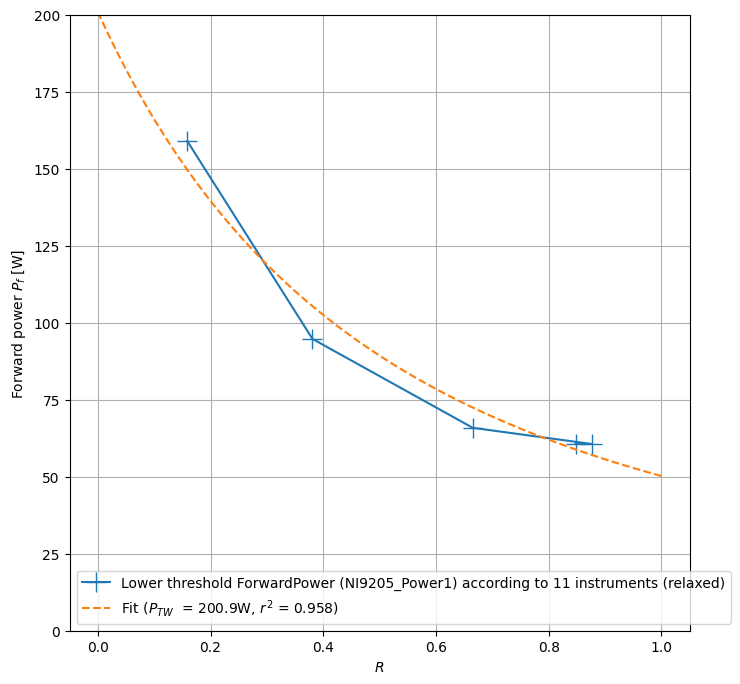

In [8]:
axe, _ = test_campaign.check_somersalo_scaling_law(
    current_multipactor_bands,
    drop_idx=[-1],
    figsize=figsize,
)
axe.set_ylim(0, 200)